In [1]:
# import libraries
import os
import requests
from zipfile import ZipFile

import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

# pd.set_option('max_rows', 30)

In [2]:
# Download and unzip it in current directory, since path is not specified
if not os.path.exists('book-crossings.zip'):
    url = 'https://cdn.freecodecamp.org/project-data/books/book-crossings.zip'
    response = requests.get(url)
    with open('book-crossings.zip', 'wb') as file:
        file.write(response.content)
    with ZipFile('book-crossings.zip', 'r') as zipObj:
        zipObj.extractall() 

In [3]:
# Import csv data into dataframes
df_books = pd.read_csv(
    'BX-Books.csv',
    encoding = "ISO-8859-1",
    sep=";",
    header=0,
    names=['isbn', 'title', 'author'],
    usecols=['isbn', 'title', 'author'],
    dtype={'isbn': 'str', 'title': 'str', 'author': 'str'})

df_ratings = pd.read_csv(
    'BX-Book-Ratings.csv',
    encoding = "ISO-8859-1",
    sep=";",
    header=0,
    names=['user', 'isbn', 'rating'],
    usecols=['user', 'isbn', 'rating'],
    dtype={'user': 'int32', 'isbn': 'str', 'rating': 'float32'})

### df_ratings exploration

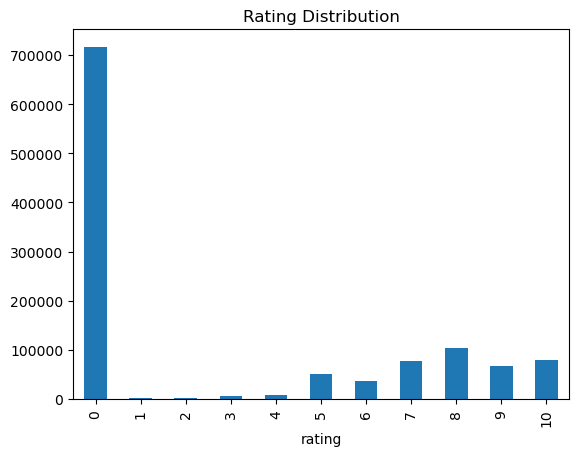

In [4]:
ax = df_ratings.rating.astype(int).value_counts().sort_index().plot(kind='bar')
ax.set_title('Rating Distribution');

* There are “0” ratings, basically meaning that the book has been read, but not rated. Usually you would remove these 
or replace them by their average value. 

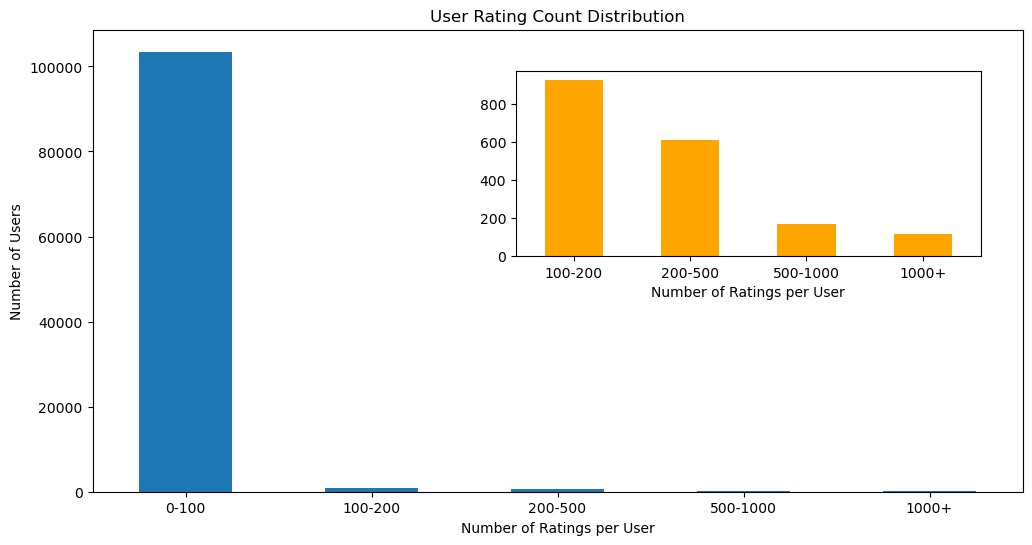

In [20]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

user_ratings_count = df_ratings.user.value_counts()
bins = pd.cut(user_ratings_count, bins=[0, 100, 200, 500, 1000, user_ratings_count.max()], labels=['0-100','100-200', '200-500', '500-1000', '1000+'])
fig, ax = plt.subplots(figsize=(12, 6))

main = bins.value_counts().sort_index().plot(kind='bar', rot=0, ax=ax)
ax.set_title('User Rating Count Distribution')
ax.set_xlabel('Number of Ratings per User')
ax.set_ylabel('Number of Users')

axins = inset_axes(ax, width='50%', height='40%', loc='upper right', borderpad=3)
bins_zoomed = bins[bins != '0-100']
bins_zoomed.value_counts().sort_index().drop('0-100').plot(kind='bar', color='orange', ax=axins, rot=0)
axins.set_xlabel('Number of Ratings per User')
plt.show()


### df_books exploratory analysis

In [4]:
print(df_books.shape)
df_books.head()

(271379, 3)


,isbn,title,author
0,0195153448,Classical Mythology,Mark P. O. Morford
1,0002005018,Clara Callan,Richard Bruce Wright
2,0060973129,Decision in Normandy,Carlo D'Este
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata
4,0393045218,The Mummies of Urumchi,E. J. W. Barber


In [11]:
df_books.dtypes

isbn      object
title     object
author    object
dtype: object

In [12]:
df_books.isna().sum()

isbn      0
title     0
author    2
dtype: int64

In [31]:
# Check for duplicate titles (keep=False keeps all duplicates, not just the first)
num = df_books.duplicated(subset='title').sum()
print(f'Found {num} total duplicate titles.')


Found 29225 total duplicate titles.


In [57]:
# Here we display all the duplicate titles (keep=False keeps all duplicates, not just the first, as above)
df_books.loc[df_books.duplicated(subset='title', keep=False)].sort_values(by='title')

,isbn,title,author
75640,1565920465,!%@ (A Nutshell handbook),Donnalyn Frey
156349,1565920317,!%@ (A Nutshell handbook),Donnalyn Frey
140624,0792276833,'A Hell of a Place to Lose a Cow': An American...,Tim Brookes
158213,0792277295,'A Hell of a Place to Lose a Cow': An American...,Tim Brookes
10439,0451168089,'Salem's Lot,Stephen King
...,...,...,...
193447,0316507490,dot.bomb: My Days and Nights at an Internet Go...,J. David Kuo
164122,158621182X,dot.bomb: My Days and Nights at an Internet Go...,J. David Kuo
193468,0316089702,dot.bomb: My Days and Nights at an Internet Go...,J. David Kuo
197396,3492233376,Ã?Â?berleben in der WÃ?Â¼ste Danakil.,RÃ?Â¼diger Nehberg


In [43]:
df_books['title'].value_counts().head(10)

title
Selected Poems                    27
Little Women                      24
Wuthering Heights                 21
The Secret Garden                 20
Dracula                           20
Adventures of Huckleberry Finn    20
Jane Eyre                         19
The Night Before Christmas        18
Pride and Prejudice               18
Great Expectations                17
Name: count, dtype: int64

In [69]:
df_books['title'].value_counts().index[0]

'Selected Poems'

In [44]:
df_books.query('title == "Little Women"')

,isbn,title,author
3952,185854176X,Little Women,Louisa M. Atcott
4330,0861782356,Little Women,Louisa May Alcott
12228,0590203509,Little Women,Louisa May Alcott
20677,0440447682,Little Women,Louisa May Alcott
32838,1550134140,Little Women,Louisa May Alcott
52213,0451529308,Little Women,Louisa May Alcott
52554,0451518144,Little Women,Louisa May Alcott
53361,0590437976,Little Women,Louisa May Alcott
57435,0195813898,Little Women,Alcott
72171,0785788727,Little Women,Louisa May Alcott


In [55]:
# Keep only the non-duplicate titles (that's not what we want)
df_books.loc[~df_books.duplicated(subset=['title'], keep=False)].reset_index(drop=True)

# To make it permanent assign a copy to df_books:
# df_books = df_books.loc[~df_books.duplicated(subset=['title'])].reset_index(drop=True).copy()

,isbn,title,author
0,0002005018,Clara Callan,Richard Bruce Wright
1,0060973129,Decision in Normandy,Carlo D'Este
2,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata
3,0393045218,The Mummies of Urumchi,E. J. W. Barber
4,0671870432,PLEADING GUILTY,Scott Turow
...,...,...,...
222242,0449906736,Flashpoints: Promise and Peril in a New World,Robin Wright
222243,0525447644,From One to One Hundred,Teri Sloat
222244,006008667X,Lily Dale : The True Story of the Town that Ta...,Christine Wicker
222245,0192126040,Republic (World's Classics),Plato


In [ ]:
df_books.nunique()

isbn      271379
title     242154
author    102042
dtype: int64

In [14]:
# All isbns and unique authors are grouped by title and sorted by the number of different copies.
# We take the unique values of the author column, with set(), and then pass them to a list.
df_books.groupby('title').agg({'isbn': list, 'author': lambda x: list(set(x))}).sort_values(by=('isbn'), key=lambda x: x.str.len(), ascending=False).head(10)

,isbn,author
title,,
Selected Poems,"[081120958X, 0811201465, 0679750800, 006093174...","[W. H. Auden, R. Jeffers, Paul Verlaine, Pablo..."
Little Women,"[185854176X, 0861782356, 0590203509, 044044768...","[Louisa M. Atcott, Louisa May Alcott, Laurie L..."
Wuthering Heights,"[0553212583, 0553211412, 0812505166, 055321021...","[EMILY BRONTE, Emily Bronte]"
The Secret Garden,"[0812505018, 0590433466, 006440188X, 059047172...","[Frances H. Burnett, Frances Hodgson Burnett, ..."
Dracula,"[156619301X, 055321148X, 9875021245, 014005280...","[Hamilton Deane, Bram Stoker, Bram Stocker, Em..."
Adventures of Huckleberry Finn,"[0835902242, 059043389X, 0451519124, 045152373...",[Mark Twain]
Jane Eyre,"[0451518845, 0451523326, 1566193028, 156619024...","[Charlotte BrontÃ?Â«, Charlotte Bronte, C Bronte]"
The Night Before Christmas,"[0505523183, 0837885043, 155858465X, 030710973...","[William Wegman, Kees Moerbeek, Clement Moore,..."
Pride and Prejudice,"[055321215X, 0553213105, 0451523652, 156619093...",[Jane Austen]


In [75]:
# Top 10 books with the most copies
df_books.groupby(['title', 'author']).agg(copies=('isbn', list), count=('isbn', 'count')).sort_values(by=('count'), ascending=False).head(10)

,,copies,count
title,author,,
Little Women,Louisa May Alcott,"[0861782356, 0590203509, 0440447682, 155013414...",21
Adventures of Huckleberry Finn,Mark Twain,"[0835902242, 059043389X, 0451519124, 045152373...",20
Wuthering Heights,Emily Bronte,"[0553211412, 0812505166, 0553210211, 043922891...",20
Pride and Prejudice,Jane Austen,"[055321215X, 0553213105, 0451523652, 156619093...",18
Dracula,Bram Stoker,"[156619301X, 055321148X, 9875021245, 014005280...",16
Great Expectations,Charles Dickens,"[0689839618, 0140434895, 0451525248, 014130932...",16
The Secret Garden,Frances Hodgson Burnett,"[0812505018, 006440188X, 0440977096, 087923649...",16
Jane Eyre,Charlotte Bronte,"[0451518845, 0451523326, 1566193028, 156619024...",16
Black Beauty,Anna Sewell,"[0440403553, 0590423541, 1588278603, 043922890...",14


In [82]:
# The same as above but with a different syntax
df_books.groupby(['title', 'author']).agg({'isbn': ['count',list]}).sort_values(by=('isbn', 'count'), ascending=False).head(10)

isbn  \
                                                       count   
title                          author                          
Little Women                   Louisa May Alcott          21   
Adventures of Huckleberry Finn Mark Twain                 20   
Wuthering Heights              Emily Bronte               20   
Pride and Prejudice            Jane Austen                18   
Dracula                        Bram Stoker                16   
Great Expectations             Charles Dickens            16   
The Secret Garden              Frances Hodgson Burnett    16   
Jane Eyre                      Charlotte Bronte           16   
Black Beauty                   Anna Sewell                14   
Emma                           Jane Austen                13   

                                                                                                           
                                                                                                     list  
title                          author                                                                      
Little Women                   Louisa May Alcott        [0861782356, 0590203509, 0440447682, 155013414...  
Adventures of Huckleberry Finn Mark Twain               [0835902242, 059043389X, 0451519124, 045152373...  
Wuthering Heights              Emily Bronte             [0553211412, 0812505166, 0553210211, 043922891...  
Pride and Prejudice            Jane Austen              [055321215X, 0553213105, 0451523652, 156619093...  
Dracula                        Bram Stoker              [156619301X, 055321148X, 9875021245, 014005280...  
Great Expectations             Charles Dickens          [0689839618, 0140434895, 0451525248, 014130932...  
The Secret Garden              Frances Hodgson Burnett  [0812505018, 006440188X, 0440977096, 087923649...  
Jane Eyre                      Charlotte Bronte         [0451518845, 0451523326, 1566193028, 156619024...  
Black Beauty                   Anna Sewell              [0440403553, 0590423541, 1588278603, 043922890...  
Emma                           Jane Austen              [0451523067, 055321019X, 0140258175, B000051WX...

In [41]:
# Find titles that contain the word 'The Hobbit'
df_books.loc[df_books['title'].str.contains('The Hobbit'), ['title']].drop_duplicates() #.reset_index(drop=True)

,title
1763,The Hobbit (Leatherette Collector's Edition)
2785,The Hobbit: or There and Back Again
3354,The Hobbit : The Enchanting Prelude to The Lor...
3356,The Hobbit
5367,"The Hobbit (Young Adult edition, Sis cover)"
6867,The Hobbit and The Lord of the Rings
14108,Lo Hobbit / The Hobbit
15678,The Hobbit: Or There and Back Again
30096,The Hobbit (Illustrated Edition)
35587,Poems from The Hobbit


### Solution
* It makes a difference whether the users or the books with too few entries are first removed.

In [42]:
user_ratings_count = df_ratings.groupby('user')['rating'].count()
book_ratings_count = df_ratings.groupby('isbn')['rating'].count()

valid_users = user_ratings_count[user_ratings_count >= 200].index
valid_books = book_ratings_count[book_ratings_count >= 100].index

filtered_df_ratings = df_ratings.query('user in @valid_users and isbn in @valid_books')

# filtered_df_ratings = df_ratings[(df_ratings['user'].isin(valid_users)) & (df_ratings['isbn'].isin(valid_books))]

In [43]:
print(filtered_df_ratings.shape)
filtered_df_ratings.head()

(49781, 3)


,user,isbn,rating
1456,277427,002542730X,10.0
1469,277427,0060930535,0.0
1471,277427,0060934417,0.0
1474,277427,0061009059,9.0
1484,277427,0140067477,0.0


In [44]:
df = pd.merge(filtered_df_ratings, df_books, on='isbn')
print(df.shape)
df.head()

(49517, 5)


,user,isbn,rating,title,author
0,277427,002542730X,10.0,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner
1,3363,002542730X,0.0,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner
2,11676,002542730X,6.0,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner
3,12538,002542730X,10.0,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner
4,13552,002542730X,0.0,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner


In [46]:
# Check for duplicate reviews of the same book by the same user:
df.loc[df.duplicated(subset=['title','user'], keep=False)].sort_values(by=['user','title'])

,user,isbn,rating,title,author
3432,254,0439064872,9.0,Harry Potter and the Chamber of Secrets (Book 2),J. K. Rowling
17923,254,0439064864,9.0,Harry Potter and the Chamber of Secrets (Book 2),J. K. Rowling
3541,254,0439136369,9.0,Harry Potter and the Prisoner of Azkaban (Book 3),J. K. Rowling
17985,254,0439136350,9.0,Harry Potter and the Prisoner of Azkaban (Book 3),J. K. Rowling
18054,6251,0439139597,10.0,Harry Potter and the Goblet of Fire (Book 4),J. K. Rowling
...,...,...,...,...,...
15358,278418,0451205421,0.0,The Door to December,Dean R. Koontz
14276,278418,0446520802,0.0,The Notebook,Nicholas Sparks
14353,278418,0446605239,0.0,The Notebook,Nicholas Sparks
3757,278418,0440225701,0.0,The Street Lawyer,JOHN GRISHAM


In [47]:
# Hence, we remove the duplicates:
df  = df.drop_duplicates(subset=["title", "user"])
df.shape

(49136, 5)

In [48]:
df.loc[df.title=='Angels &amp; Demons']['isbn'].unique()

array(['0671027360'], dtype=object)

In [49]:
# Create a pivot table where the rows are the titles and the columns are the users and the values are the ratings.
df_pivot = df.pivot_table(index='title', columns='user', values='rating').fillna(0)

# Convert the pivot table to a sparse matrix to save memory (zero values are not stored).
df_matrix = csr_matrix(df_pivot.values)

In [50]:
# Shape of the pivot table derives from the number of unique titles and users:
df.title.nunique(), df.user.nunique()

(673, 888)

In [51]:
# Model learns to identify books that are similar to each other based on the user ratings.
# This similarity is measured using distance metrics, like cosine similarity.
model = NearestNeighbors(metric='cosine', algorithm='brute')
model.fit(df_matrix)

NearestNeighbors(algorithm='brute', metric='cosine')

In [85]:
# book = '1984'
# idx = df_pivot.index.get_loc(book)
# n=5
# distances, indices = model.kneighbors(df_pivot.iloc[idx,:].values.reshape(1, -1), n_neighbors=n+1)

# indices -> [[0 509 51 463 409 511]]
# distances -> [[0. 0.6145346  0.61507255 0.61652744 0.61707735 0.61707735]]

# ndarray 

In [52]:
# function to return recommended books - this will be tested
def get_recommends(book = "", n = 5):
  try:
    idx = df_pivot.index.get_loc(book)
  except KeyError as error:
    print(f'Book {error} not found.')
    return None
  
  # Select the first n+1 nearest neighbors, since the first one is the book itself
  # select a row from the pivot table, reshape to 2D array as expected by kneighbors(), with shape (1, whatever)
  distances, indices = model.kneighbors(df_pivot.iloc[idx,:].values.reshape(1, -1), n_neighbors=n+1)
  
  # Flatten the 2D numpy array into a 1D array, similar to distances[0], indices[0]
  recommended = []
  for distance, indice in zip(distances.flatten(), indices.flatten()):
    rec_book = df_pivot.index[indice]
    if rec_book != book:
      recommended.append((rec_book, distance))
  
  # Distance between the books (lower is better) vs cos(distance) (higher would be better)
  # we reverse the order of the list, since there is a misconception in the test function
  recommended_books = [book, recommended[::-1]]
  
  return recommended_books

In [53]:
get_recommends("lord of the rings")

Book 'lord of the rings' not found.


In [54]:
get_recommends("The Queen of the Damned (Vampire Chronicles (Paperback))")

['The Queen of the Damned (Vampire Chronicles (Paperback))',
 [('Catch 22', 0.7939835),
  ('The Witching Hour (Lives of the Mayfair Witches)', 0.74486566),
  ('Interview with the Vampire', 0.73450685),
  ('The Tale of the Body Thief (Vampire Chronicles (Paperback))', 0.53763384),
  ('The Vampire Lestat (Vampire Chronicles, Book II)', 0.51784116)]]

In [55]:
books = get_recommends("Where the Heart Is (Oprah's Book Club (Paperback))")
print(books)

def test_book_recommendation():
  test_pass = True
  recommends = get_recommends("Where the Heart Is (Oprah's Book Club (Paperback))")
  if recommends[0] != "Where the Heart Is (Oprah's Book Club (Paperback))":
    test_pass = False
  recommended_books = ["I'll Be Seeing You", 'The Weight of Water', 'The Surgeon', 'I Know This Much Is True', 'The Lovely Bones: A Novel']
  recommended_books_dist = [0.8, 0.77, 0.77, 0.77, 0.72]
  for i in range(len(recommended_books)):
    if recommends[1][i][0] not in recommended_books:
      test_pass = False
    if abs(recommends[1][i][1] - recommended_books_dist[i]) >= 0.05:
      test_pass = False
  if test_pass:
    print("You passed the challenge! 🎉🎉🎉🎉🎉")
  else:
    print("You haven't passed yet. Keep trying!")

test_book_recommendation()

["Where the Heart Is (Oprah's Book Club (Paperback))", [("I'll Be Seeing You", 0.8016211), ('The Weight of Water', 0.77085835), ('The Surgeon', 0.7699411), ('I Know This Much Is True', 0.7677075), ('The Lovely Bones: A Novel', 0.7234864)]]
You passed the challenge! 🎉🎉🎉🎉🎉
